In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, MaxPooling3D, Dense, Flatten
from keras.models import Model

**Autoencoder for Unsupervised Classification \
Advanced Physics Project \
11 August 2024**

In [33]:
# Checking GPU availability for GPU acceleration
print('Num GPUs available:', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs available: 1


In [34]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Loading the dataset containing images from a URL and extracting it
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)

# Creating the directories
base_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'validation')

In [35]:
model_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Creating the training and validation generators that will be used to train and validate the model
train_generator = model_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='input',
    subset='training'
)

validation_generator = model_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='input',
    subset='validation'
)

# Creating the generator that will allow for testing with unseen images
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    shuffle=True
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [36]:
# Creating the autoencoder layers
input_img = Input(shape=(150, 150, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 3), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((1, 1), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((1, 1))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((3, 3))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='rmsprop', loss='mse')
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 25, 25, 64)        3692

In [37]:
# Training the model and defining the flow of data settings
history = autoencoder.fit(
    train_generator,
    steps_per_epoch=16,  # 1600 images = batch_size * steps
    epochs=20,
    validation_data=validation_generator,
    validation_steps=4,  # 400 images = batch_size * steps
    shuffle=True,
    verbose=2)

Epoch 1/20
16/16 - 7s - loss: 0.0712 - val_loss: 0.0643 - 7s/epoch - 441ms/step
Epoch 2/20
16/16 - 5s - loss: 0.0484 - val_loss: 0.0514 - 5s/epoch - 302ms/step
Epoch 3/20
16/16 - 5s - loss: 0.0368 - val_loss: 0.0466 - 5s/epoch - 295ms/step
Epoch 4/20
16/16 - 5s - loss: 0.0281 - val_loss: 0.0609 - 5s/epoch - 282ms/step
Epoch 5/20
16/16 - 4s - loss: 0.0267 - val_loss: 0.0270 - 4s/epoch - 272ms/step
Epoch 6/20
16/16 - 5s - loss: 0.0232 - val_loss: 0.0194 - 5s/epoch - 284ms/step
Epoch 7/20
16/16 - 4s - loss: 0.0204 - val_loss: 0.0149 - 4s/epoch - 274ms/step
Epoch 8/20
16/16 - 4s - loss: 0.0193 - val_loss: 0.0221 - 4s/epoch - 266ms/step
Epoch 9/20
16/16 - 4s - loss: 0.0195 - val_loss: 0.0136 - 4s/epoch - 270ms/step
Epoch 10/20
16/16 - 5s - loss: 0.0177 - val_loss: 0.0158 - 5s/epoch - 284ms/step
Epoch 11/20
16/16 - 5s - loss: 0.0178 - val_loss: 0.0140 - 5s/epoch - 285ms/step
Epoch 12/20
16/16 - 4s - loss: 0.0154 - val_loss: 0.0185 - 4s/epoch - 264ms/step
Epoch 13/20
16/16 - 4s - loss: 0.0152

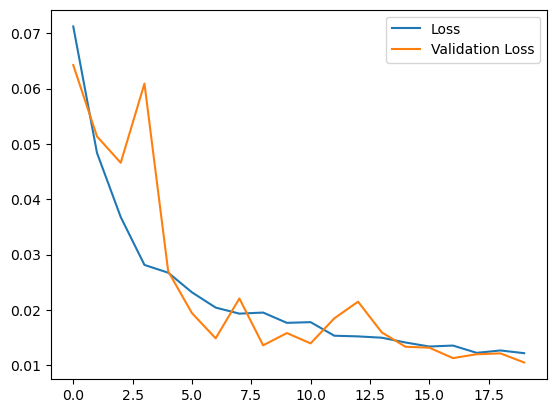

In [38]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 124ms/step


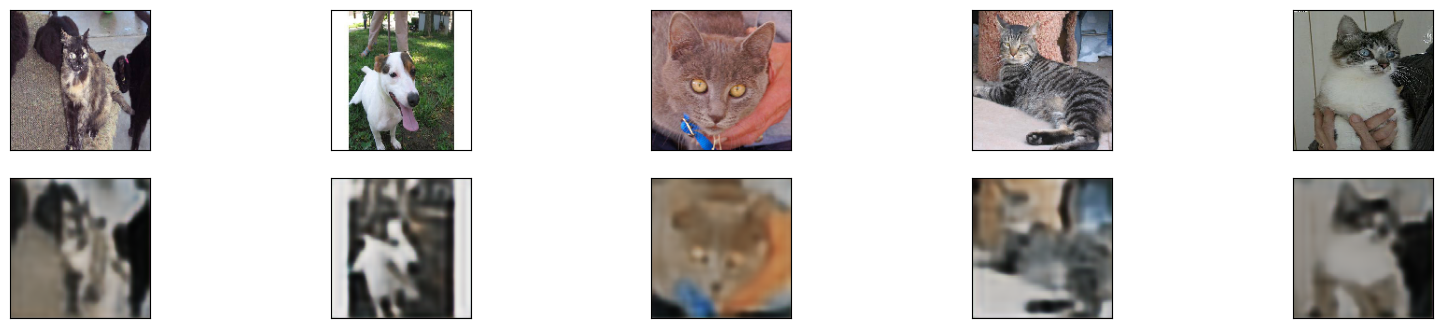

In [39]:
# Getting one batch of test images
X_test, Y_test = next(test_generator)

# Getting corresponding decoded images
decoded_images = autoencoder.predict(X_test)

# Checking and displaying the first 5 images
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display Original images
    ax = plt.subplot(2, n, i + 1)
    original = X_test[i].reshape(150, 150, 3)
    plt.imshow(original)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Reconstruction images
    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed = decoded_images[i].reshape(150, 150, 3)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [45]:
# Creating the training and validation generators that will be used to train and validate the classifier model
train_generator = model_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='binary',
    subset='training'
)

validation_generator = model_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='binary',
    subset='validation'
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [46]:
encoder = Model(input_img, encoded)

In [47]:
# Building a simple classifier using the encoder
x = Flatten()(encoded)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
classifier = Model(input_img, x)

In [48]:
classifier.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 25, 25, 64)        369

In [49]:
# Training the model and defining the flow of data settings
classifier.fit(
    train_generator,
    steps_per_epoch=16,  # 1600 images = batch_size * steps
    epochs=20,
    validation_data=validation_generator,
    validation_steps=4,  # 400 images = batch_size * steps
    shuffle=True,
    verbose=2)

Epoch 1/20
16/16 - 5s - loss: 0.7686 - accuracy: 0.5512 - val_loss: 0.7463 - val_accuracy: 0.5000 - 5s/epoch - 340ms/step
Epoch 2/20
16/16 - 4s - loss: 0.7306 - accuracy: 0.6219 - val_loss: 0.7553 - val_accuracy: 0.5075 - 4s/epoch - 233ms/step
Epoch 3/20
16/16 - 4s - loss: 0.6113 - accuracy: 0.6762 - val_loss: 0.7190 - val_accuracy: 0.5975 - 4s/epoch - 253ms/step
Epoch 4/20
16/16 - 4s - loss: 0.5927 - accuracy: 0.6988 - val_loss: 0.6263 - val_accuracy: 0.6525 - 4s/epoch - 225ms/step
Epoch 5/20
16/16 - 4s - loss: 0.5120 - accuracy: 0.7500 - val_loss: 0.6840 - val_accuracy: 0.6450 - 4s/epoch - 268ms/step
Epoch 6/20
16/16 - 4s - loss: 0.4371 - accuracy: 0.8044 - val_loss: 0.6487 - val_accuracy: 0.6525 - 4s/epoch - 227ms/step
Epoch 7/20
16/16 - 4s - loss: 0.3957 - accuracy: 0.8325 - val_loss: 0.7687 - val_accuracy: 0.6525 - 4s/epoch - 279ms/step
Epoch 8/20
16/16 - 4s - loss: 0.3547 - accuracy: 0.8406 - val_loss: 0.7559 - val_accuracy: 0.6450 - 4s/epoch - 239ms/step
Epoch 9/20
16/16 - 4s - 

1/1 [==============================] - 0s 94ms/step


TypeError: only length-1 arrays can be converted to Python scalars

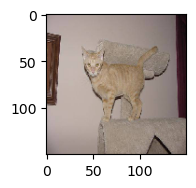

In [50]:
# Getting one batch of test images
X_test, Y_test = next(test_generator)

# Predicting the classes
predictions = classifier.predict(X_test)

# Displaying the first 5 images and their predicted classes
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(150, 150, 3))
    plt.title(f"Actual: {int(Y_test[i])} | Predicted: {int(predictions[i] > 0.5)}")
    plt.axis('off')
plt.show()